### **Uploading all needed files since I'm working on colab**

In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [1]:
from google.colab import files
import os

print("Uploading all needed files since I'm working on colab")
print("1. model.py")
print("2. mitigate.py")
print("3. best_model_weights.pth")
print("4. quantum_dataset_long.csv")

uploaded = files.upload()
required_files = ['model.py', 'mitigate.py', 'best_model_weights.pth', 'quantum_dataset_long.csv']
for file in required_files:
    if file not in uploaded:
        print(f"WARNING: forgot to upload '{file}'")
    else:
        print(f"Found '{file}'")

Uploading all needed files since I'm working on colab
1. model.py
2. mitigate.py
3. best_model_weights.pth
4. quantum_dataset_long.csv


Saving quantum_dataset_long.csv to quantum_dataset_long.csv
Saving mitigate.py to mitigate.py
Saving model.py to model.py
Saving best_model_weights.pth to best_model_weights.pth
Found 'model.py'
Found 'mitigate.py'
Found 'best_model_weights.pth'
Found 'quantum_dataset_long.csv'


### **Organizing the Folder Structure**

In [2]:
import shutil

os.makedirs("Core_Code", exist_ok=True)
os.makedirs("Data", exist_ok=True)

try:
    shutil.move("model.py", "Core_Code/model.py")
    shutil.move("mitigate.py", "Core_Code/mitigate.py")
    shutil.move("best_model_weights.pth", "Core_Code/best_model_weights.pth")
    shutil.move("quantum_dataset_long.csv", "Data/quantum_dataset_long.csv")
    print("Files moved to correct folders.")
except FileNotFoundError as e:
    print(f"Error moving files: {e}. Did you upload them in Step 1?")

# 3. Add Core_Code to path so I can import modules
import sys
sys.path.append(os.path.abspath("Core_Code"))

Files moved to correct folders.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import API
try:
    from mitigate import QEM_API
    print("API Imported Successfully")
except ImportError:
    print("API Import Failed. Check Core_Code folder.")

# 1. SETUP & TRAINING
df = pd.read_csv("Data/quantum_dataset_long.csv")

# Prepare Data
input_cols = [f"noisy_{i}" for i in range(16)]
target_cols = [f"ideal_{i}" for i in range(16)]
X_all = df[input_cols].values
Y_all = df[target_cols].values
meta_all = df[["n_qubits", "n_gates", "depth", "noise_level"]].values

# Split Data
X_train, X_test, Y_train, Y_test, meta_train, meta_test = train_test_split(
    X_all, Y_all, meta_all, test_size=0.2, random_state=42
)

# Train Baseline
baseline_model = LinearRegression()
baseline_model.fit(X_train, Y_train)

# Load Oour model
mitigator = QEM_API(weights_path="Core_Code/best_model_weights.pth")


# 2. BENCHMAKRING LOOP
def calculate_fidelity(p_ideal, p_pred):
    return np.square(np.sum(np.sqrt(np.maximum(0, p_ideal * p_pred))))

results = []
# Test on 500 samples
print(f"\nRunning Benchmark on 500 circuits")
for i in range(500):
    noisy = X_test[i]
    ideal = Y_test[i]
    meta = meta_test[i]

    # our model prediction
    ai_pred = mitigator.mitigate(noisy, meta)

    # Baseline Prediction
    base_pred = baseline_model.predict([noisy])[0]
    base_pred = np.clip(base_pred, 0, 1)
    if base_pred.sum() > 0: base_pred /= base_pred.sum()

    # Metrics
    results.append({
        "Depth": int(meta[2]),
        "Fidelity_Raw": calculate_fidelity(ideal, noisy),
        "Fidelity_Base": calculate_fidelity(ideal, base_pred),
        "Fidelity_AI": calculate_fidelity(ideal, ai_pred),
        "MSE_Raw": np.mean((ideal - noisy)**2),
        "MSE_AI": np.mean((ideal - ai_pred)**2)
    })

res_df = pd.DataFrame(results)

API Imported Successfully

Running Benchmark on 500 circuits


In [18]:
results = []

for i in range(500):
    noisy = X_test[i]
    ideal = Y_test[i]
    meta = meta_test[i]

    # AI Prediction
    ai_pred = mitigator.mitigate(noisy, meta)

    # Baseline Prediction
    base_pred = baseline_model.predict([noisy])[0]
    base_pred = np.clip(base_pred, 0, 1)
    if base_pred.sum() > 0: base_pred /= base_pred.sum()

    # Metrics
    results.append({
        "Depth": int(meta[2]),
        "Noise": meta[3],
        "Fidelity_Raw": calculate_fidelity(ideal, noisy),
        "Fidelity_Base": calculate_fidelity(ideal, base_pred),
        "Fidelity_AI": calculate_fidelity(ideal, ai_pred),
        "MSE_Raw": np.mean((ideal - noisy)**2),
        "MSE_AI": np.mean((ideal - ai_pred)**2)
    })

res_df = pd.DataFrame(results)

# 3. RESULTS
print("\n" + "="*60)
print("FINAL SCORECARD")
print("="*60)
print(f"{'Metric':<20} | {'Raw Noise':<10} | {'Baseline':<10} | {'Our Model':<10}")
print("-" * 60)
print(f"{'Avg Fidelity':<20} | {res_df['Fidelity_Raw'].mean():.4f}     | {res_df['Fidelity_Base'].mean():.4f}     | {res_df['Fidelity_AI'].mean():.4f}")
print("-" * 60)
imp_factor = res_df['MSE_Raw'].mean() / res_df['MSE_AI'].mean()
print(f"Improvement Factor: {imp_factor:.2f}x better than noise")


FINAL SCORECARD
Metric               | Raw Noise  | Baseline   | Our Model 
------------------------------------------------------------
Avg Fidelity         | 0.4996     | 0.5821     | 0.6925
------------------------------------------------------------
Improvement Factor: 1.80x better than noise


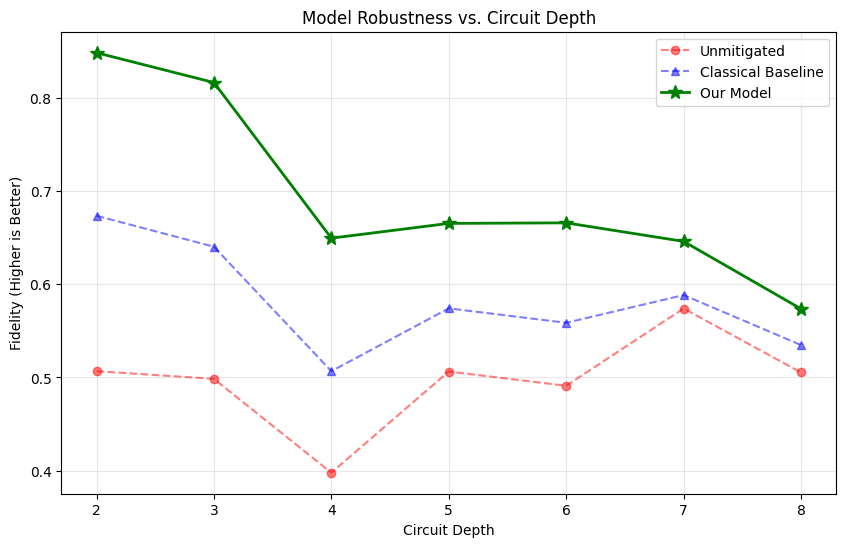

In [19]:
plt.figure(figsize=(10, 6))
# Group by depth to get clean lines
scaling = res_df.groupby("Depth")[["Fidelity_Raw", "Fidelity_Base", "Fidelity_AI"]].mean()

plt.plot(scaling.index, scaling["Fidelity_Raw"], 'r--o', label="Unmitigated", alpha=0.5)
plt.plot(scaling.index, scaling["Fidelity_Base"], 'b--^', label="Classical Baseline", alpha=0.5)
plt.plot(scaling.index, scaling["Fidelity_AI"], 'g-*', label="Our Model", linewidth=2, markersize=10)

plt.xlabel("Circuit Depth")
plt.ylabel("Fidelity (Higher is Better)")
plt.title("Model Robustness vs. Circuit Depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

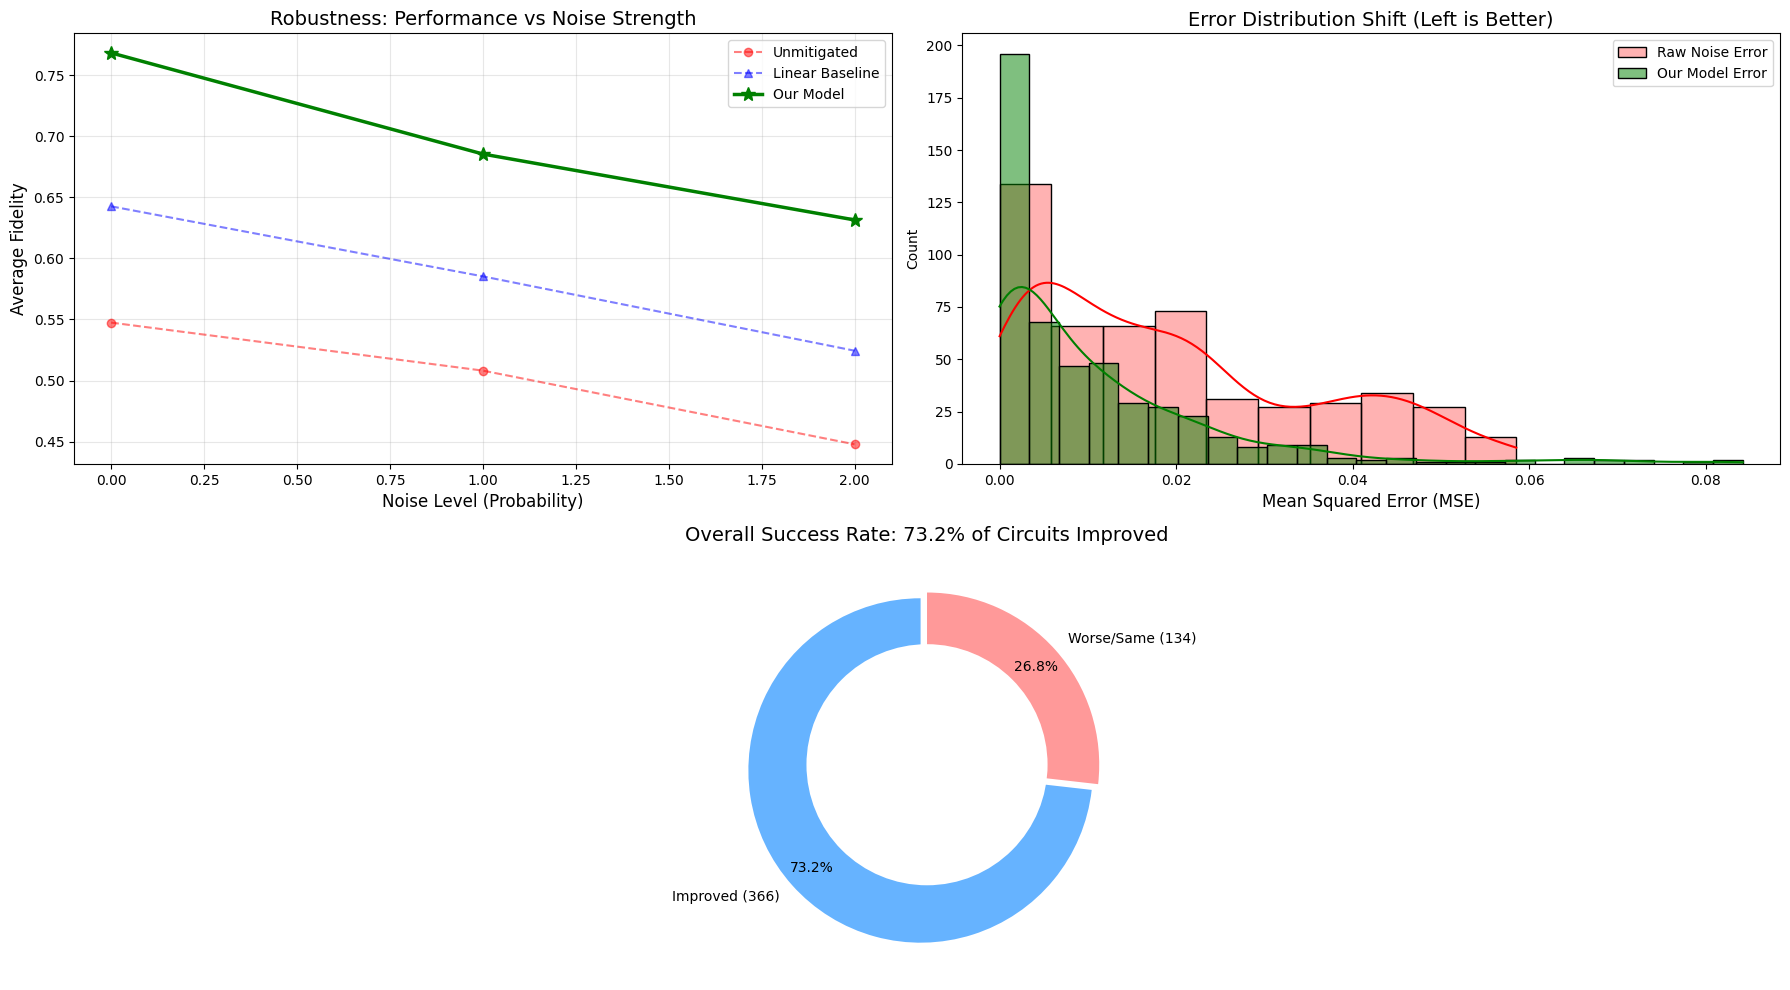

In [20]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

# PLOT 1: Robustness to Noise Levels (Line Plot)
ax1 = fig.add_subplot(gs[0, 0])
noise_scaling = res_df.groupby("Noise")[["Fidelity_Raw", "Fidelity_AI", "Fidelity_Base"]].mean()

ax1.plot(noise_scaling.index, noise_scaling["Fidelity_Raw"], 'r--o', label="Unmitigated", alpha=0.5)
ax1.plot(noise_scaling.index, noise_scaling["Fidelity_Base"], 'b--^', label="Linear Baseline", alpha=0.5)
ax1.plot(noise_scaling.index, noise_scaling["Fidelity_AI"], 'g-*', label="Our Model", linewidth=2.5, markersize=10)

ax1.set_title("Robustness: Performance vs Noise Strength", fontsize=14)
ax1.set_xlabel("Noise Level (Probability)", fontsize=12)
ax1.set_ylabel("Average Fidelity", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# PLOT 2: Error Distribution Shift (Histogram)
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(res_df['MSE_Raw'], color="red", label="Raw Noise Error", kde=True, ax=ax2, alpha=0.3)
sns.histplot(res_df['MSE_AI'], color="green", label="Our Model Error", kde=True, ax=ax2, alpha=0.5)

ax2.set_title("Error Distribution Shift (Left is Better)", fontsize=14)
ax2.set_xlabel("Mean Squared Error (MSE)", fontsize=12)
ax2.legend()

# PLOT 3: The "Win Rate" (Pie Chart)
ax3 = fig.add_subplot(gs[1, :])

wins = np.sum(res_df['MSE_AI'] < res_df['MSE_Raw'])
losses = len(res_df) - wins
win_rate = (wins / len(res_df)) * 100

labels = [f'Improved ({wins})', f'Worse/Same ({losses})']
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)

ax3.pie([wins, losses], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax3.add_artist(centre_circle)

ax3.set_title(f"Overall Success Rate: {win_rate:.1f}% of Circuits Improved", fontsize=14)

plt.tight_layout()
plt.show()

---
---
---

## **Benchmarking on QAOA**

In [16]:
!pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.2 MB/s eta 0:00:00


In [44]:
from model import QuantumErrorMitigator

print("Phase 1: Generating QAOA Data (approx. 200 samples)...")

# Setup Simulation
noise_level = 0.01  # We train on a fixed noise level for stability
noise_model = NoiseModel()
error = depolarizing_error(noise_level, 1)
error_2 = depolarizing_error(noise_level, 2)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

sim_ideal = AerSimulator()
sim_noisy = AerSimulator(noise_model=noise_model)

qubit_op = SparsePauliOp.from_list([("ZZII", 1), ("IZZI", 1), ("IIZZ", 1), ("ZIIZ", 1)])

new_data = []

for i in tqdm(range(200), desc="Generating QAOA"):
    # 1. Create Random QAOA Circuit
    ansatz = QAOAAnsatz(cost_operator=qubit_op, reps=1, name="QAOA_MaxCut")
    params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
    ansatz.assign_parameters(params, inplace=True)
    ansatz.measure_all()

    # 2. Transpile & Get Metadata
    t_circuit = transpile(ansatz, sim_noisy)
    depth = t_circuit.depth()
    gates = sum(t_circuit.count_ops().values())

    # 3. Run Sims
    job_ideal = sim_ideal.run(t_circuit, shots=5000)
    job_noisy = sim_noisy.run(t_circuit, shots=5000)

    counts_ideal = job_ideal.result().get_counts()
    counts_noisy = job_noisy.result().get_counts()

    # 4. Convert to Probabilities
    def get_probs(counts):
        probs = np.zeros(16)
        total = sum(counts.values())
        for k, v in counts.items():
            probs[int(k, 2)] = v / total
        return probs

    p_ideal = get_probs(counts_ideal)
    p_noisy = get_probs(counts_noisy)

    # 5. Build Row
    # Columns: n_qubits, n_gates, depth, noise_level, noisy_0..15, ideal_0..15
    row = [4, gates, depth, noise_level]
    row.extend(p_noisy)
    row.extend(p_ideal)
    new_data.append(row)

Phase 1: Generating QAOA Data (approx. 200 samples)...


Generating QAOA:   0%|          | 0/200 [00:00<?, ?it/s]

In [45]:
# Load existing CSV and append
df_orig = pd.read_csv("Data/quantum_dataset_long.csv")
cols = df_orig.columns
df_new = pd.DataFrame(new_data, columns=cols)
df_combined = pd.concat([df_orig, df_new], ignore_index=True)

# Save the updated dataset
df_combined.to_csv("Data/quantum_dataset_updated.csv", index=False)
print(f"Data Merged. New Size: {len(df_combined)} samples.")


# PART 2: RETRAIN THE MODEL
print("\nPhase 2: Retraining Model on Mixed Data...")

# Prepare Tensors
input_cols = ["n_qubits", "n_gates", "depth", "noise_level"] + [f"noisy_{i}" for i in range(16)]
target_cols = [f"ideal_{i}" for i in range(16)]

X = df_combined[input_cols].values.astype(np.float32)
Y = df_combined[target_cols].values.astype(np.float32)

# Use 100% of data for training since we want max performance
dataset = TensorDataset(torch.tensor(X), torch.tensor(Y))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumErrorMitigator().to(device)

# FINE TUNING with the new samples
try:
    model.load_state_dict(torch.load("Core_Code/best_model_weights.pth"))
    print("Loaded previous weights. Fine-tuning...")
except:
    print("Starting training from scratch")

Data Merged. New Size: 30200 samples.

Phase 2: Retraining Model on Mixed Data...
Loaded previous weights. Fine-tuning...


In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Lower LR for fine-tuning
criterion = nn.KLDivLoss(reduction='batchmean')

# Train Loop
EPOCHS = 20 # Quick fine-tuning
model.train()

for epoch in tqdm(range(EPOCHS), desc="Training"):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        log_preds = model(batch_x)
        loss = criterion(log_preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# Save NEW weights
torch.save(model.state_dict(), "Core_Code/best_model_weights_updated.pth")
print("Training Complete")
print("Saved new weights to: Core_Code/best_model_weights_updated.pth")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete
Saved new weights to: Core_Code/best_model_weights_updated.pth


In [49]:
sys.path.append(os.path.abspath("Core_Code"))
from model import QuantumErrorMitigator

# PART 1: GENERATE QAOA DATA (Data Augmentation)
print("Phase 1: Generating QAOA Data (approx. 200 samples)")

# Setup Simulation
noise_level = 0.01  # Fixed noise level for training stability
noise_model = NoiseModel()
error = depolarizing_error(noise_level, 1)
error_2 = depolarizing_error(noise_level, 2)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

sim_ideal = AerSimulator()
sim_noisy = AerSimulator(noise_model=noise_model)

qubit_op = SparsePauliOp.from_list([("ZZII", 1), ("IZZI", 1), ("IIZZ", 1), ("ZIIZ", 1)])

new_data = []

for i in tqdm(range(200), desc="Generating QAOA"):
    # 1. Create Random QAOA Circuit
    ansatz = QAOAAnsatz(cost_operator=qubit_op, reps=1, name="QAOA_MaxCut")
    params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
    ansatz.assign_parameters(params, inplace=True)
    ansatz.measure_all()

    # 2. Transpile & Get Real Metadata
    t_circuit = transpile(ansatz, sim_noisy)
    depth = t_circuit.depth()
    gates = sum(t_circuit.count_ops().values())

    # 3. Run Sims
    job_ideal = sim_ideal.run(t_circuit, shots=5000)
    job_noisy = sim_noisy.run(t_circuit, shots=5000)

    counts_ideal = job_ideal.result().get_counts()
    counts_noisy = job_noisy.result().get_counts()

    # 4. Convert to Probabilities
    def get_probs(counts):
        probs = np.zeros(16)
        total = sum(counts.values())
        for k, v in counts.items():
            probs[int(k, 2)] = v / total
        return probs

    p_ideal = get_probs(counts_ideal)
    p_noisy = get_probs(counts_noisy)

    # Columns: n_qubits, n_gates, depth, noise_level, noisy_0..15, ideal_0..15
    row = [4, gates, depth, noise_level]
    row.extend(p_noisy)
    row.extend(p_ideal)
    new_data.append(row)

# Load existing CSV and append
try:
    df_orig = pd.read_csv("Data/quantum_dataset_long.csv")
    cols = df_orig.columns
    df_new = pd.DataFrame(new_data, columns=cols)
    df_combined = pd.concat([df_orig, df_new], ignore_index=True)

    # Save the updated dataset
    df_combined.to_csv("Data/quantum_dataset_updated.csv", index=False)
    print(f"Data Merged. New Size: {len(df_combined)} samples.")
except FileNotFoundError:
    print("Error: Could not find Data/quantum_dataset_long.csv. Make sure it exists.")

# PART 2: RETRAIN THE MODEL
print("\nPhase 2: Retraining Model on Mixed Data...")

# Prepare Tensors
input_cols = ["n_qubits", "n_gates", "depth", "noise_level"] + [f"noisy_{i}" for i in range(16)]
target_cols = [f"ideal_{i}" for i in range(16)]

X = df_combined[input_cols].values.astype(np.float32)
Y = df_combined[target_cols].values.astype(np.float32)

dataset = TensorDataset(torch.tensor(X), torch.tensor(Y))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumErrorMitigator().to(device)

# fine tuning
try:
    model.load_state_dict(torch.load("Core_Code/best_model_weights.pth"))
    print("Loaded previous weights. Fine-tuning..")
except:
    print("Starting training from scratch")

optimizer = optim.Adam(model.parameters(), lr=0.0001) # Lower LR for fine-tuning
criterion = nn.KLDivLoss(reduction='batchmean')

# Train Loop
EPOCHS = 20 # Quick fine-tuning
model.train()

for epoch in tqdm(range(EPOCHS), desc="Training"):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        log_preds = model(batch_x)
        loss = criterion(log_preds, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# Save NEW weights
torch.save(model.state_dict(), "Core_Code/best_model_weights_updated.pth")
print("Training Complete")
print("Saved new weights to: Core_Code/best_model_weights_updated.pth")

Phase 1: Generating QAOA Data (approx. 200 samples)


Generating QAOA:   0%|          | 0/200 [00:00<?, ?it/s]

Data Merged. New Size: 30200 samples.

Phase 2: Retraining Model on Mixed Data...
Loaded previous weights. Fine-tuning..


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Complete
Saved new weights to: Core_Code/best_model_weights_updated.pth


In [86]:
from mitigate import QEM_API

# 1. SETUP & CONFIGURATION
weights_file = "Core_Code/best_model_weights_updated.pth"
dataset_file = "Data/quantum_dataset_updated.csv"

N_SAMPLES = 10
NOISE_LEVEL = 0.05

# 2. TRAIN THE BASELINE
print(f"Training Linear Baseline on {dataset_file}")
try:
    df = pd.read_csv(dataset_file)
    X_train = df[[f"noisy_{i}" for i in range(16)]].values
    Y_train = df[[f"ideal_{i}" for i in range(16)]].values

    baseline_model = LinearRegression()
    baseline_model.fit(X_train, Y_train)
    print("Baseline Trained.")
except FileNotFoundError:
    print("Error: Could not find dataset.")
    baseline_model = LinearRegression()
    baseline_model.fit(np.random.rand(10, 16), np.random.rand(10, 16))

Training Linear Baseline on Data/quantum_dataset_updated.csv
Baseline Trained.


In [87]:
# 3. LOAD OUR MODEL
print("Loading AI Model...")
mitigator = QEM_API(weights_path=weights_file)

# 4. SIMULATION SETUP
print(f"Running benchmark on {N_SAMPLES} QAOA circuits..")
noise_model = NoiseModel()
error = depolarizing_error(NOISE_LEVEL, 1)
error_2 = depolarizing_error(NOISE_LEVEL, 2)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

sim_ideal = AerSimulator()
sim_noisy = AerSimulator(noise_model=noise_model)
qubit_op = SparsePauliOp.from_list([("ZZII", 1), ("IZZI", 1), ("IIZZ", 1), ("ZIIZ", 1)])

mse_raw_list = []
mse_base_list = []
mse_ai_list = []
best_improvement = -1
best_data = None

Loading AI Model...
Running benchmark on 10 QAOA circuits..



QAOA BENCHMARK SCORECARD (10 Samples)
Metric               | Raw Noise  | Baseline   | Our Model 
------------------------------------------------------------
Avg MSE              | 0.000334     | 0.000867     | 0.000304
------------------------------------------------------------
Our Model Improvement vs Noise:    1.10x
Our Model Improvement vs Baseline: 2.85x


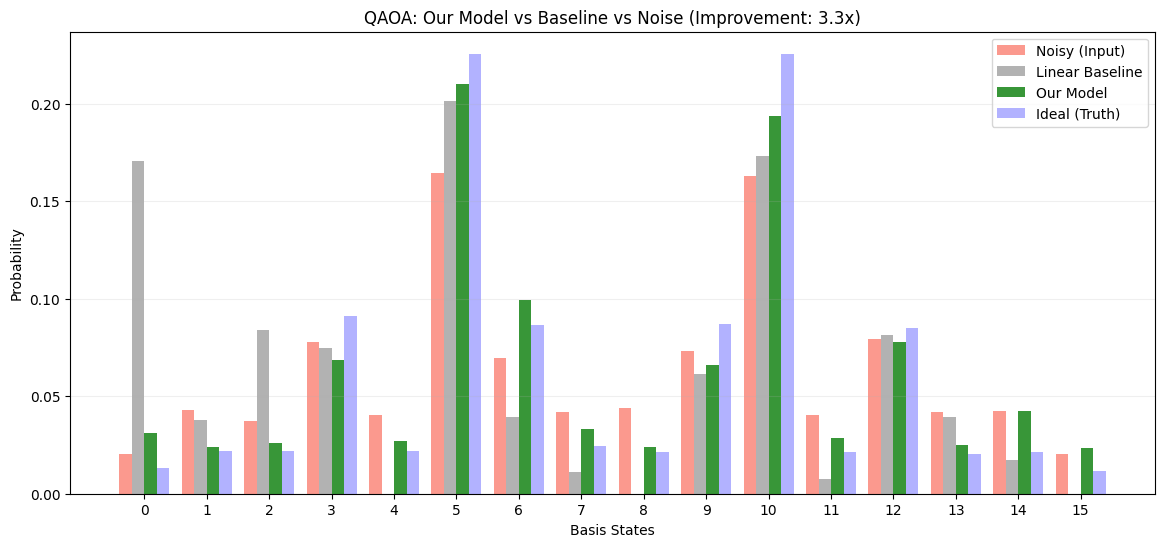

In [93]:
# 5. THE BENCHMARK LOOP
for i in range(N_SAMPLES):
    # A. Generate Circuit
    ansatz = QAOAAnsatz(cost_operator=qubit_op, reps=1, name="QAOA_MaxCut")
    params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
    ansatz.assign_parameters(params, inplace=True)
    ansatz.measure_all()

    # B. Transpile
    t_circuit = transpile(ansatz, sim_noisy)
    real_depth = t_circuit.depth()
    real_gates = sum(t_circuit.count_ops().values())

    # C. Run Simulator
    job_ideal = sim_ideal.run(t_circuit, shots=10000)
    counts_ideal = job_ideal.result().get_counts()
    job_noisy = sim_noisy.run(t_circuit, shots=10000)
    counts_noisy = job_noisy.result().get_counts()

    # D. Process Probs
    def get_probs(counts):
        probs = np.zeros(16)
        total = sum(counts.values())
        for k, v in counts.items():
            probs[int(k, 2)] = v / total
        return probs

    probs_ideal = get_probs(counts_ideal)
    probs_noisy = get_probs(counts_noisy)

    # E. MITIGATE (AI vs Baseline)
    # AI Prediction
    metadata = [4, real_gates, real_depth, NOISE_LEVEL]
    probs_ai = mitigator.mitigate(probs_noisy, metadata)

    # Baseline Prediction
    probs_base = baseline_model.predict([probs_noisy])[0]
    probs_base = np.clip(probs_base, 0, 1) # Force physical validity
    if probs_base.sum() > 0: probs_base /= probs_base.sum()

    # F. Calculate Errors
    mse_raw = np.mean((probs_ideal - probs_noisy)**2)
    mse_base = np.mean((probs_ideal - probs_base)**2)
    mse_ai = np.mean((probs_ideal - probs_ai)**2)

    mse_raw_list.append(mse_raw)
    mse_base_list.append(mse_base)
    mse_ai_list.append(mse_ai)

    imp = mse_raw / (mse_ai + 1e-9)
    if imp > best_improvement:
        best_improvement = imp
        best_data = (probs_ideal, probs_noisy, probs_base, probs_ai)

avg_mse_raw = np.mean(mse_raw_list)
avg_mse_base = np.mean(mse_base_list)
avg_mse_ai = np.mean(mse_ai_list)

print("\n" + "="*60)
print(f"QAOA BENCHMARK SCORECARD ({N_SAMPLES} Samples)")
print("="*60)
print(f"{'Metric':<20} | {'Raw Noise':<10} | {'Baseline':<10} | {'Our Model':<10}")
print("-" * 60)
print(f"{'Avg MSE':<20} | {avg_mse_raw:.6f}     | {avg_mse_base:.6f}     | {avg_mse_ai:.6f}")
print("-" * 60)
print(f"Our Model Improvement vs Noise:    {avg_mse_raw/avg_mse_ai:.2f}x")
print(f"Our Model Improvement vs Baseline: {avg_mse_base/avg_mse_ai:.2f}x")

# 7. VISUALIZATION
probs_ideal, probs_noisy, probs_base, probs_ai = best_data

plt.figure(figsize=(14, 6))
x = np.arange(16)
width = 0.2

plt.bar(x - 1.5*width, probs_noisy, width, label='Noisy (Input)', color='salmon', alpha=0.8)
plt.bar(x - 0.5*width, probs_base, width, label='Linear Baseline', color='gray', alpha=0.6)
plt.bar(x + 0.5*width, probs_ai, width, label='Our Model', color='forestgreen', alpha=0.9)
plt.bar(x + 1.5*width, probs_ideal, width, label='Ideal (Truth)', color='blue', alpha=0.3)

plt.xlabel("Basis States")
plt.ylabel("Probability")
plt.title(f"QAOA: Our Model vs Baseline vs Noise (Improvement: {best_improvement:.1f}x)")
plt.legend()
plt.xticks(x)
plt.grid(axis='y', alpha=0.2)
plt.show()